In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap

plt.rcParams['text.usetex'] = True
colors = ["#0072BD","#D95319","#EDB120","#7E2F8E","#77AC30","#4DBEEE","#A2142F"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## Generate data

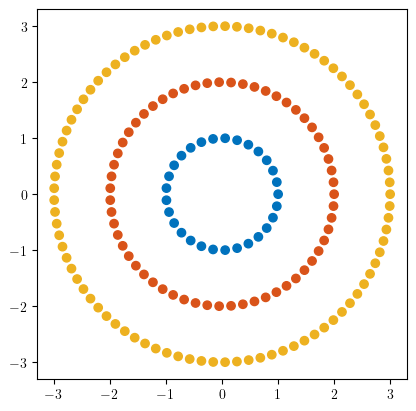

In [2]:
# make points on a circle
def make_circle(radius, density=30):
    """
    Make an array of evenly spaced points on a circle of a specified radius.
    Spacing of the points is determined by the density (default is 30 points per 2π arc length).
    """
    th = np.linspace(start=0,
                     stop=2 * np.pi,
                     num=int(radius * density)-1,
                     endpoint=False)
    x = radius * np.cos(th)
    y = radius * np.sin(th)
    return np.column_stack([x, y])

# generate data matrix
rs = [1,2,3]
X = np.row_stack([make_circle(r) for r in rs])
labels = np.sqrt(X[:,0]**2 + X[:,1]**2)

# make color map for plot
cmap = ListedColormap(colors[:len(rs)])
# plot
ax = plt.axes(aspect='equal')
ax.scatter(*X.T, c=labels, cmap=cmap)
plt.show()

## Fit kernel PCA with Scikit Learn

We use the Scikit Learn `KernelPCA` class to fit a kernel transform to the circle data.
The radial basis function kernel is implemented as
$$
\operatorname{rbf}(x,y) = \exp\left(-\gamma \|x-y\|^2\right).
$$
Comparing this to the Gaussian kernel in terms of $\sigma$,
$$
\exp\left(-\frac{\|x-y\|^2}{2\sigma^2}\right)
\implies \gamma = \frac{1}{2\sigma^2}
\implies \sigma = \frac{1}{\sqrt{2 \gamma}}.
$$

In [3]:
from sklearn.decomposition import KernelPCA

# set parameter
gamma = 5
sigma = 1 / np.sqrt(2 * gamma)

# fit kernel PCA
kernel_pca = KernelPCA(n_components=3, kernel="rbf", gamma=gamma)
kpca_fit = kernel_pca.fit(X)
kpca_X, kpca_Y, kpca_Z = kpca_fit.transform(X).T

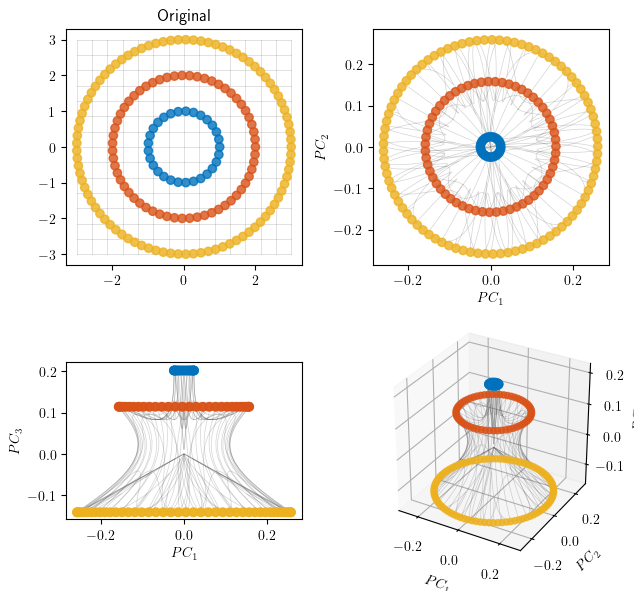

In [4]:
# set up axes for plotting
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(221) # plot original data
ax2 = fig.add_subplot(222) # plot PC1 vs PC2
ax3 = fig.add_subplot(223) # plot PC1 vs PC3
ax4 = fig.add_subplot(224, projection='3d') # plot PC1, PC2, PC3

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')

# axis labels
ax1.set_title("Original")

ax2.set_xlabel("$PC_1$")
ax2.set_ylabel("$PC_2$")

ax3.set_xlabel("$PC_1$")
ax3.set_ylabel("$PC_3$")

ax4.set_xlabel("$PC_1$")
ax4.set_ylabel("$PC_2$")
ax4.set_zlabel("$PC_3$")

# plotting properties
cmap = ListedColormap(colors[:len(rs)])
pt_props = {
    "c": labels,  # marker color
    "cmap": cmap, # color map
    "alpha": .8,  # transparency
    "zorder": 2.5 # plot points over lines
}
grid_props = {
    "color": '#555', # line color
    "linewidth": .5, # line width
    "alpha": .25     # transparency
}

# plot grid
def plot_grid(x,y):
    xy = np.column_stack((x, y))
    pc1, pc2, pc3 = kpca_fit.transform(xy).T
    ax1.plot(x, y, **grid_props)
    ax2.plot(pc1, pc2, **grid_props)
    ax3.plot(pc1, pc3, **grid_props)
    ax4.plot(pc1, pc2, pc3, **grid_props)

# create grid lines
xmin, ymin = X.min(0)
xmax, ymax = X.max(0)
xs, ys = np.meshgrid(np.linspace(xmin, xmax, 100),
                     np.linspace(ymin, ymax, 15))
# loop over lines
for x, y in zip(xs, ys):
    plot_grid(x,y) # vertical grid lines
    plot_grid(y,x) # horizontal grid lines

# plot
ax1.scatter(*X.T, **pt_props)                   # original xy data
ax2.scatter(kpca_X, kpca_Y, **pt_props)         # PC1, PC2
ax3.scatter(kpca_X, kpca_Z, **pt_props)         # PC1, PC3
ax4.scatter(kpca_X, kpca_Y, kpca_Z, **pt_props) # PC1, PC2, PC3

# save figure
fig.subplots_adjust(wspace=.3)
fig.savefig("fig_kpca_example.pdf")
plt.show()

# Do KPCA algorithm

1. create kernel matrix
2. center kernel matrix
3. decompose kernel matrix
4. get principal components
5. project along PCs

In [5]:
# compute centered pairwise kernel matrix
def pairwise_kernels(kernel, X, Y=None):
    # make sure X is a numpy array
    X = np.asarray(X)
    # compute pairwise kernel matrix if Y is provided
    # otherwise, compute kernel matrix for X
    if Y is None:
        Y = X
    # create kernel matrix
    K = np.array([[kernel(x,y) for x in X] for y in Y])
    # centering
    cmean = K.mean(0)[:,np.newaxis].T # make row vector of column means
    rmean = K.mean(1)[:,np.newaxis]   # make column vector of row means
    Kmean = K.mean()                  # matrix mean
    return K - cmean - rmean + Kmean

def kpca_decomp(kernel, X, n_components=None):
    # make sure X is a numpy array
    X = np.asarray(X)
    # if the number of components is not specified, then use all
    if n_components is None:
        n_components = X.shape[0]
    # compute kernel matrix
    K = pairwise_kernels(kernel, X)
    # decompose (SVD sorts the eigenvalues in descending order)
    eigenvecs, eigenvals, _ = np.linalg.svd(K, hermitian=True)
    # reduce number of components used
    eigenvecs = eigenvecs[:,:n_components]
    eigenvals = eigenvals[:n_components]
    # scale components
    eigenvecs = eigenvecs / np.sqrt(eigenvals)
    # make largest entry of each eigenvector positive
    idx = np.abs(eigenvecs).argmax(0)
    jdx = range(eigenvecs.shape[1])
    signs = np.sign(eigenvecs[idx,jdx])
    eigenvecs = eigenvecs * signs
    return eigenvecs, eigenvals

# compute KPCA transform
# def kpca_transform(kernel, X_train, Y=None, n_components=None):
#     alphas, lambdas = kpca_decomp(kernel, X_train, n_components=n_components)
#     if Y is None:
#         ret = alphas * lambdas
#     else:
#         ret = pairwise_kernels(kernel, X_train, Y) @ alphas
#     return ret

# generate gaussian kernel
def make_gaussian_kernel(std):
    sqnorm = lambda x : np.linalg.norm(x)**2
    var2 = 2 * std**2
    return lambda x,y : np.exp(-sqnorm(x-y)/var2)

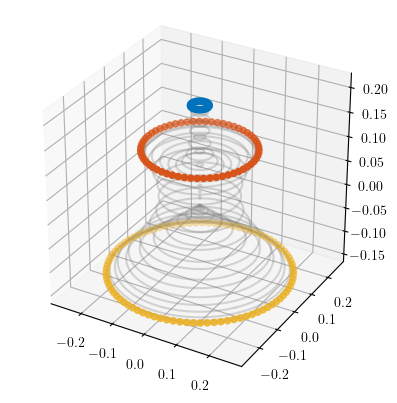

In [48]:
# get kernel parameter (make sure it matches Scikit parameter)
gamma = kpca_fit.get_params()['gamma']
sigma = 1/np.sqrt(2*gamma)
kernel = make_gaussian_kernel(sigma)

# transform X
X_new = kpca_transform(kernel, X, n_components=3)

# transform new data
# Y = make_circle(1.5)
# Y_new = kpca_transform(kernel, X, Y=Y, n_components=3)

ax = plt.axes(projection='3d', aspect='equal')
for r in np.linspace(.1,4,50):
    circs = kpca_fit.transform(make_circle(r))
    circs = np.row_stack([circs, circs[0]])
    ax.plot(*circs.T, color='gray', alpha=.3, zorder=.1)
ax.scatter(*X_new.T, c=labels, cmap=cmap)
# ax.scatter(*Y_new.T, color=colors[3])

plt.show()

In [ ]:
# set up axes for plotting
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(221) # plot original data
ax2 = fig.add_subplot(222) # plot PC1 vs PC2
ax3 = fig.add_subplot(223) # plot PC1 vs PC3
ax4 = fig.add_subplot(224, projection='3d') # plot PC1, PC2, PC3

for ax in ax1, ax2, ax3, ax4:
    ax.set_aspect('equal')


for r in np.linspace(.1,3,50):
    Y = make_circle(r,100)
    xx, yy, zz = kpca_fit.transform(Y).T
    # xx, yy, zz = kpca_transform(kernel, X, Y=Y, n_components=3).T
    ax1.plot(*Y.T)
    ax2.plot(xx, yy)
    ax3.plot(xx, zz)
    ax4.plot(xx, yy, zz)

plt.show()